In [1]:
# загружаем необходимые библиотеки
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import warnings

warnings.filterwarnings("ignore")

np.random.seed(1)

%matplotlib inline
# загружаем датафрейм
df = pd.read_csv("discountuplift.csv", sep="\t")


# реализуем подсчёт Qini Score:
def qini_df(df):
    # отранжируем выборку по значению uplift в порядке убывания
    ranked = df.sort_values("uplift_score", ascending=False)

    N_c = sum(ranked["target_class"] <= 1)
    N_t = sum(ranked["target_class"] >= 2)

    # посчитаем в отсортированном датафрейме основные показатели,
    # которые используются при расчёте Qini Score
    ranked["n_c1"] = 0
    ranked["n_t1"] = 0
    ranked.loc[ranked.target_class == 1, "n_c1"] = 1
    ranked.loc[ranked.target_class == 3, "n_t1"] = 1
    ranked["n_c1/nc"] = ranked.n_c1.cumsum() / N_c
    ranked["n_t1/nt"] = ranked.n_t1.cumsum() / N_t

    # посчитаем Qini-кривую и случайную прямую под ней
    ranked["uplift"] = round(ranked["n_t1/nt"] - ranked["n_c1/nc"], 5)
    # добавим случайную кривую
    ranked["random_uplift"] = round(
        ranked["uplift_score"].rank(pct=True, ascending=False)
        * ranked["uplift"].iloc[-1],
        5,
    )

    ranked["n"] = ranked["uplift_score"].rank(pct=True, ascending=False)
    # немного кода для визуализации
    plt.plot(ranked["n"], ranked["uplift"], color="r")
    plt.plot(ranked["n"], ranked["random_uplift"], color="b")
    plt.show()

    return (ranked["uplift"] - ranked["random_uplift"]).sum()


df["old_target"] = (df["target_class"] % 2).apply(int)

feature_cols = [
    "recency",
    "history",
    "used_discount",
    "used_bogo",
    "is_referral",
    "zip_code_Rural",
    "zip_code_Surburban",
    "zip_code_Urban",
    "channel_Multichannel",
    "channel_Phone",
    "channel_Web",
]
target_col = "old_target"
treatment_col = "treatment"

from sklearn.model_selection import train_test_split

df_train, df_test = train_test_split(
    df, stratify=df[[treatment_col, target_col]], random_state=1, test_size=0.25
)

from sklearn.linear_model import LogisticRegression

In [2]:
!pip install causalml

  Using cached forestci-0.6-py3-none-any.whl.metadata (1.3 kB)
  Using cached pathos-0.2.9-py3-none-any.whl.metadata (11 kB)
  Using cached xgboost-2.1.3-py3-none-manylinux_2_28_x86_64.whl.metadata (2.1 kB)
  Using cached pydotplus-2.0.2.tar.gz (278 kB)
  Preparing metadata (setup.py) ... done
  Using cached lightgbm-4.5.0-py3-none-manylinux_2_28_x86_64.whl.metadata (17 kB)
  Using cached pygam-0.9.1-py3-none-any.whl.metadata (7.1 kB)
  Using cached ppft-1.7.6.9-py3-none-any.whl.metadata (12 kB)
  Using cached pox-0.3.5-py3-none-any.whl.metadata (8.0 kB)
  Using cached progressbar2-4.5.0-py3-none-any.whl.metadata (16 kB)
  Using cached slicer-0.0.8-py3-none-any.whl.metadata (4.0 kB)
  Using cached nvidia_nccl_cu12-2.23.4-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached dill-0.3.9-py3-none-any.whl.metadata (10 kB)
  Using cached python_utils-3.9.1-py2.py3-none-any.whl.metadata (9.8 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 4.7 MB/s eta 0:00:00a 0:00:01

In [3]:
# Задание 1 из 2
# Начнём с обучения S-learner на основе логистической регрессии.
# С помощью библиотеки Causal ML настройте автоматизацию обучения, которое ранее вы осуществляли вручную.

from causalml.inference.meta import BaseSClassifier

s_learner = BaseSClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
s_learner.fit(
    X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col]
)

uplift_vals = s_learner.predict(np.array(df_test[feature_cols].values.copy()))
uplift_vals

array([[0.06375855],
       [0.06572023],
       [0.06644343],
       ...,
       [0.04883641],
       [0.04192834],
       [0.07620716]])

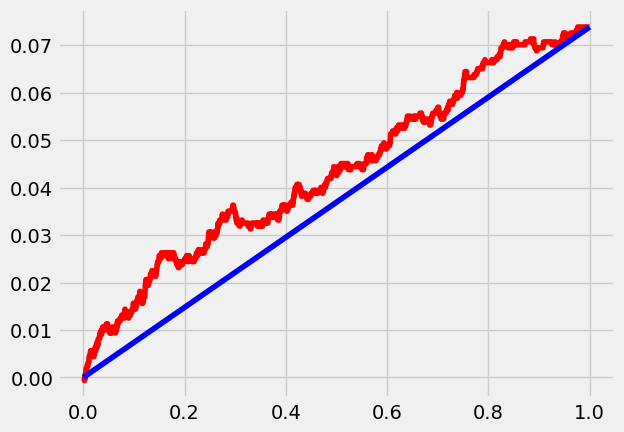

20.995829999999998

In [4]:
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)

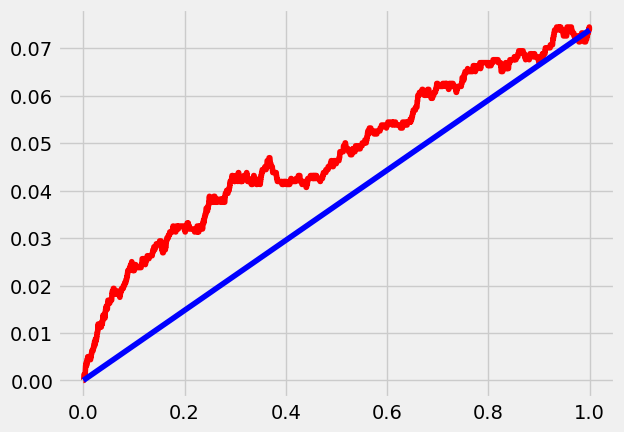

34.1297

In [5]:
from causalml.inference.meta import BaseTClassifier

t_learner = BaseTClassifier(learner=LogisticRegression(random_state=1, verbose=0))

# для обучения нам нужны датафрейм с факторами и колонка с фактом воздействия
t_learner.fit(
    X=df_train[feature_cols], treatment=df_train[treatment_col], y=df_train[target_col]
)

uplift_vals = t_learner.predict(np.array(df_test[feature_cols].values.copy()))

# оцените качество
df_test["uplift_score"] = uplift_vals

# посчитаем Qini Score по нашему датасету
qini_df(df_test)